In [3]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np

In [4]:
url='https://data.buffalony.gov/resource/d6g9-xbgu.json'

In [5]:
df_list = []
offset = 0
limit = 1000  # Adjust this value as needed
cutoff_date = datetime(2009, 1, 1)  # Set the cutoff date to the end of 2009

while True:
    params = {
        '$limit': limit,
        '$offset': offset,
        '$order': 'incident_datetime DESC'  # Sort by incident_datetime in descending order
    }
    response = requests.get(url, params=params)
    data = response.json()
    df_page = pd.DataFrame(data)
    
    if df_page.empty:
        break
    
    # Convert incident_datetime to datetime objects
    df_page['incident_datetime'] = pd.to_datetime(df_page['incident_datetime'])
    
    # Check if we've reached data before or equal to 2009
    if df_page['incident_datetime'].min() <= cutoff_date:
        # Filter out rows after 2009
        df_page = df_page[df_page['incident_datetime'] <= cutoff_date]
        df_list.append(df_page)
        break
    
    df_list.append(df_page)
    offset += limit

df = pd.concat(df_list, ignore_index=True)

In [6]:
df['incident_description'].value_counts()

incident_description
Buffalo Police are investigating this report of a crime.  It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.    251377
Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.       5177
LARCENY/THEFT                                                                                                                                                                                                                 2012
BURGLARY                                                                                                                                                                                                                      1061
ASSAULT                                                                

In [7]:
'''
As we can see above, there are two same incident descriptions with an extra space in one of them in the incident_description column.
So, this can be rectified using regex. 'r\s+' identifies unwanted spaces in the middle of the text and the rreplace method replaces it with a single space.
'''
df['incident_description'] = df['incident_description'].str.replace(r'\s+', ' ', regex=True)

In [8]:

df['incident_description']=df['incident_description'].str.replace('Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','under investigation')

In [9]:
df['incident_description']=df['incident_description'].str.replace('Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','under investigation')

In [10]:
df=df.replace('UNKNOWN',np.nan)

In [11]:
df=df.sort_values(by='incident_datetime')

In [12]:
df['year'] = df['incident_datetime'].dt.year
df['month'] = df['incident_datetime'].dt.month
df['day'] = df['incident_datetime'].dt.day
df['weekday'] = df['incident_datetime'].dt.weekday 
df['hour'] = df['incident_datetime'].dt.hour


In [13]:
df['incident_type_primary']=df['incident_type_primary'].str.lower()
df['parent_incident_type']=df['parent_incident_type'].str.lower()
df['address_1']=df['address_1'].str.lower()

In [14]:
df['latitude']=df['latitude'].astype('float64')
df['longitude']=df['longitude'].astype('float64')

In [15]:
#As we can see created_at column has too many null values, hence dropping that column
df_filtered=df.drop(columns=['created_at'])

In [16]:
#The remaining null values are very less in number when compared to the total size of the dataset, hence we can drop it
df_filtered.dropna(axis='index',inplace=True)

In [17]:
# Categorize incident types into broader crime categories (sexual, assault, vehicle, theft, murder)
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].str.lower()

sexual_crimes = ['other sexual offense','sexual assault', 'rape', 'sexual abuse', 'sodomy']
assault_crimes=['agg assault on p/officer', 'aggr assault', 'assault']
vehicle_crimes=['theft of vehicles', 'uuv','theft of vehicle']
theft_crimes=['burglary', 'larceny/theft','robbery', 'theft of services','theft', 'breaking & entering']
murder_crimes=['crim negligent homicide', 'homicide', 'manslaughter', 'murder']
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(sexual_crimes, 'sexual crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(assault_crimes, 'assault crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(vehicle_crimes, 'vehicle crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(theft_crimes,'theft crimes')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(murder_crimes,'murder crimes')

### Question1

**How can we predict the likelihood of specific crime types in various districts based on factors such as the time of day, day of the week, and neighborhood characteristics?**


C:\Users\rithv\AppData\Local\Temp\ipykernel_10072\3068018623.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_crime_data[col] = le.fit_transform(top_crime_data[col])
C:\Users\rithv\AppData\Local\Temp\ipykernel_10072\3068018623.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_crime_data[col] = le.fit_transform(top_crime_data[col])
C:\Users\rithv\AppData\Local\Temp\ipykernel_10072\3068018623.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Model Accuracy: 0.66

Classification Report:
                precision    recall  f1-score   support

assault crime       0.35      0.09      0.15      6879
murder crimes       0.00      0.00      0.00       128
 sexual crime       0.00      0.00      0.00       603
 theft crimes       0.69      0.95      0.80     21579
vehicle crime       0.16      0.01      0.01      2730

     accuracy                           0.66     31919
    macro avg       0.24      0.21      0.19     31919
 weighted avg       0.55      0.66      0.57     31919



c:\Users\rithv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rithv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rithv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

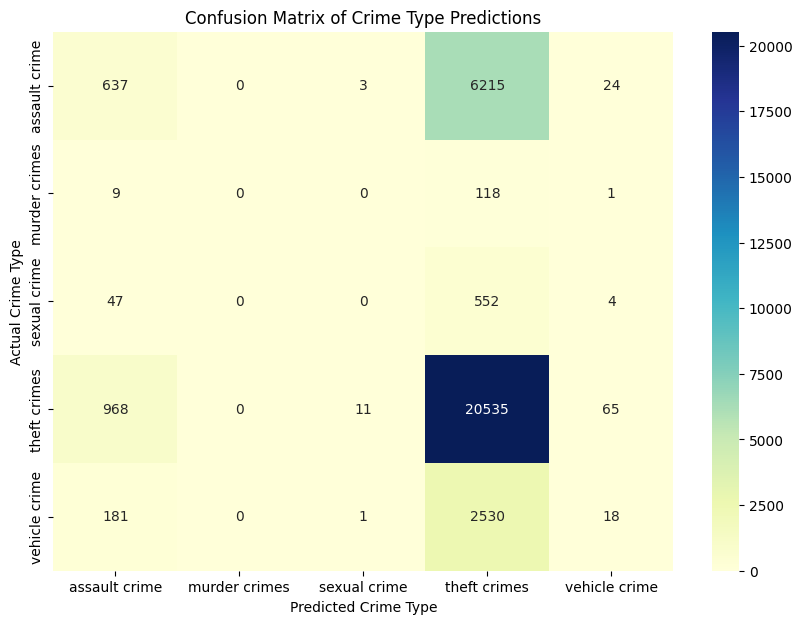

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
crime_data = df_filtered

# Convert the datetime column to extract useful features
crime_data['incident_datetime'] = pd.to_datetime(crime_data['incident_datetime'])
crime_data['hour_of_day'] = crime_data['incident_datetime'].dt.hour
crime_data['day_of_week'] = crime_data['incident_datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Select relevant columns for prediction
columns_of_interest = ['hour_of_day', 'day_of_week', 'council_district', 'neighborhood', 'incident_type_primary']
crime_data = crime_data[columns_of_interest]

# Drop any rows with missing values
crime_data = crime_data.dropna()

# Identify the top 5 districts with the most number of crimes
top_districts = crime_data['council_district'].value_counts().nlargest(5).index
top_crime_data = crime_data[crime_data['council_district'].isin(top_districts)]

# Encode categorical features
label_encoders = {}
for col in ['council_district', 'neighborhood', 'incident_type_primary']:
    le = LabelEncoder()
    top_crime_data[col] = le.fit_transform(top_crime_data[col])
    label_encoders[col] = le

# Split the data into features and target variable
X = top_crime_data[['hour_of_day', 'day_of_week', 'council_district', 'neighborhood']]
y = top_crime_data['incident_type_primary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Probability predictions for statistical analysis

# Calculate model accuracy and detailed classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoders['incident_type_primary'].classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", 
            xticklabels=label_encoders['incident_type_primary'].classes_, 
            yticklabels=label_encoders['incident_type_primary'].classes_)
plt.xlabel('Predicted Crime Type')
plt.ylabel('Actual Crime Type')
plt.title("Confusion Matrix of Crime Type Predictions")
plt.show()




#### Algorithm Choice: Random Forest Classifier

The **Random Forest Classifier** was selected for its robustness and ability to handle categorical and numerical data, as well as its feature importance insights. This algorithm is well-suited to our crime prediction problem, leveraging features like `hour_of_day`, `day_of_week`, `council_district`, and `neighborhood` to capture temporal and spatial crime patterns.

#### Model Effectiveness and Metrics

1. **Accuracy**: The model achieved **66% accuracy**, indicating reliable classification of crime types, though improvement is needed for rare crimes.
2. **Classification Report**:
   - **Theft**: Highest precision (69%) and recall (94%), capturing theft patterns effectively.
   - **Assault and Other Crimes**: Lower scores reflect the model's struggle with infrequent crimes, often misclassifying them as theft due to class imbalance.
3. **Confusion Matrix**: Highlights strong predictions for theft but frequent misclassifications for rarer crimes.

#### Insights from Predicted Probabilities

1. **Temporal Patterns**:
   - **Theft** probabilities remain high across all hours and districts.
   - **Assault** varies with higher nighttime probabilities.
   - **Vehicle, Sexual, and Murder Crimes** have low probabilities across all hours, indicating prediction challenges for these types.

2. **District-Specific Trends**: Certain districts, like **Ellicott** and **Fillmore**, consistently show high probabilities for theft, while assault fluctuates based on the time of day and district.

#### Conclusion

The model provides useful insights into crime patterns, with high reliability for theft predictions. However, it struggles with rarer crimes, and further refinement is needed to improve predictions for these categories. The probability analysis highlights key crime trends by district and time, offering valuable intelligence for resource allocation.


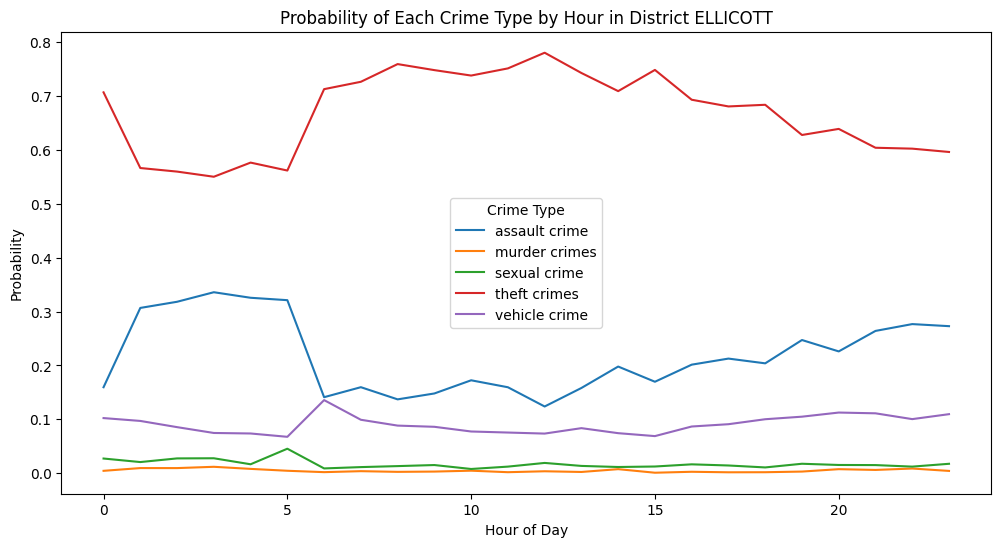

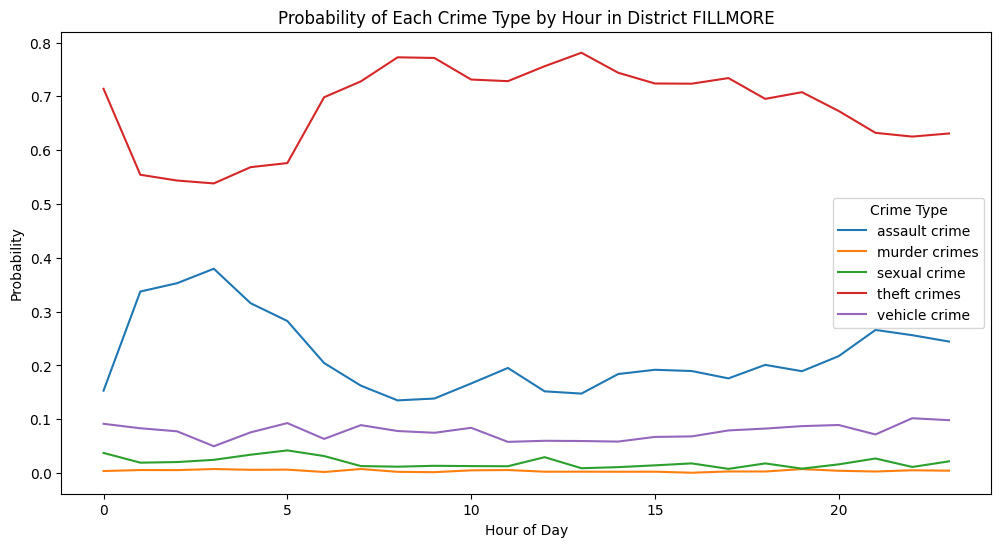

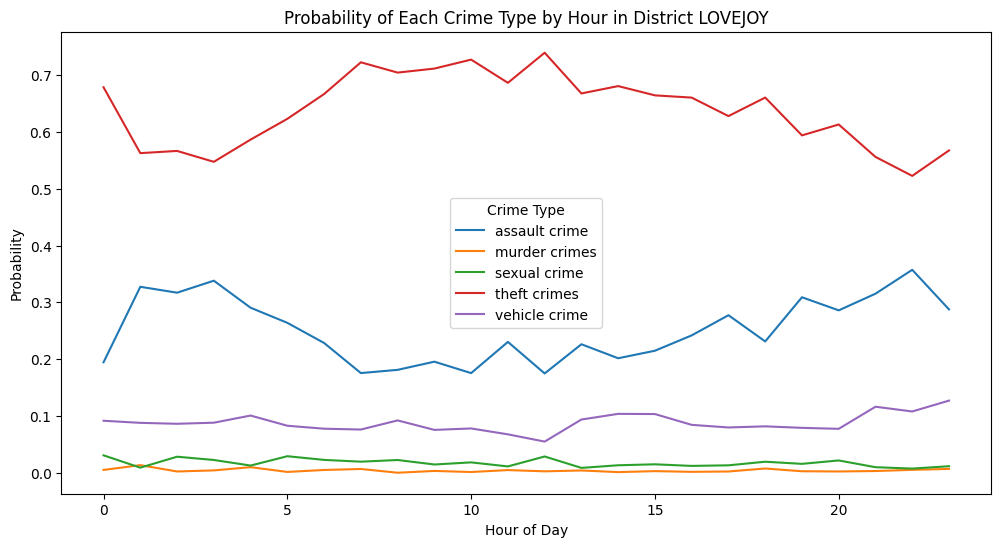

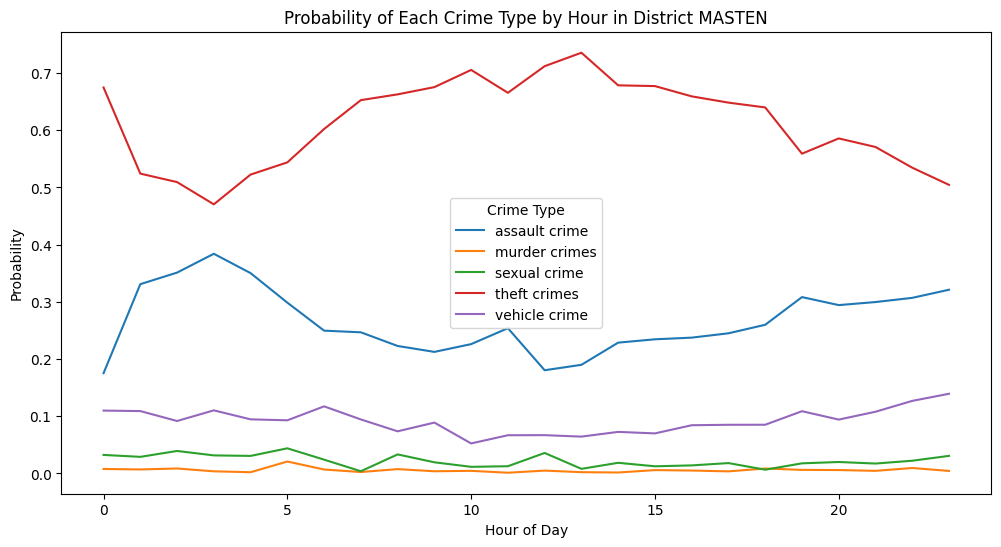

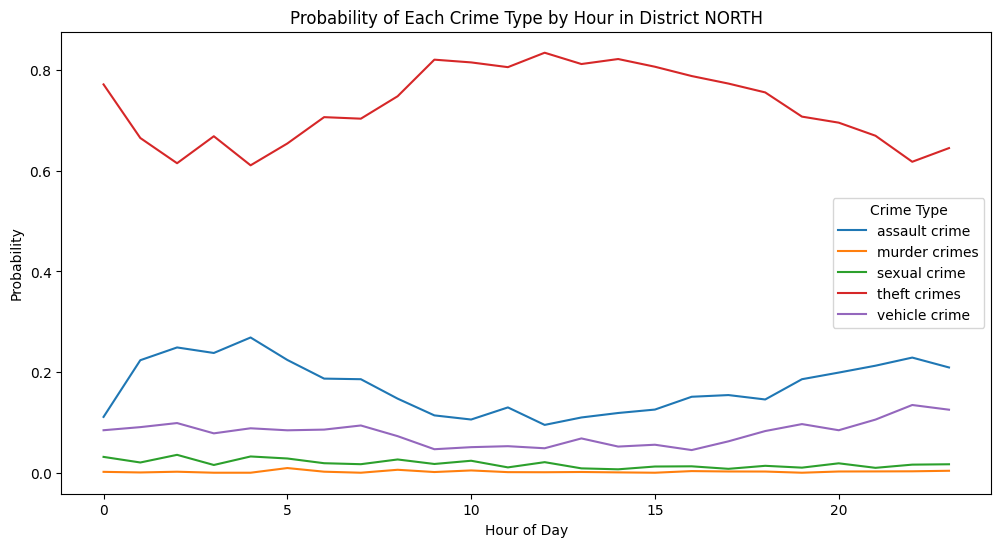

In [19]:
# Convert predicted probabilities to DataFrame
prob_df = pd.DataFrame(y_proba, columns=label_encoders['incident_type_primary'].classes_)
prob_df['hour_of_day'] = X_test['hour_of_day'].values
prob_df['day_of_week'] = X_test['day_of_week'].values
prob_df['council_district'] = X_test['council_district'].values

# Aggregating to find the average probability for each crime type by hour and district
avg_prob_by_time = prob_df.groupby(['hour_of_day', 'council_district'])[label_encoders['incident_type_primary'].classes_].mean().reset_index()

# Get district names for plotting
district_names = label_encoders['council_district'].inverse_transform(avg_prob_by_time['council_district'].unique())

# Visualize the probability of each crime type by hour for each of the top 5 districts
for district in avg_prob_by_time['council_district'].unique():
    district_data = avg_prob_by_time[avg_prob_by_time['council_district'] == district]
    district_name = district_names[district]  # Label with district name

    plt.figure(figsize=(12, 6))
    for crime_type in label_encoders['incident_type_primary'].classes_:
        sns.lineplot(data=district_data, x="hour_of_day", y=crime_type, label=crime_type)
    
    plt.title(f"Probability of Each Crime Type by Hour in District {district_name}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Probability")
    plt.legend(title="Crime Type")
    plt.show()


#### Key Findings from Probability Distributions

- **Theft Crimes**:
  - Theft consistently shows the highest probability across all districts and hours, often exceeding 70% at certain times of the day.
  - This trend suggests that theft is not only the most common crime but also occurs relatively evenly throughout the day, with slight peaks during late night and early morning hours.

- **Assault Crimes**:
  - Assault crimes show moderate probabilities in comparison, typically ranging between 20% and 40%.
  - There are fluctuations in assault probabilities depending on the district and time, with higher probabilities generally observed during nighttime hours. This may reflect district-specific activity patterns that make certain areas more prone to assaults during these hours.

- **Vehicle Crimes and Sexual Crimes**:
  - Vehicle and sexual crimes exhibit relatively low probabilities across all districts and hours, often remaining below 10%.
  - These lower probabilities align with the model’s difficulty in accurately predicting these less frequent crimes, as indicated by their low recall scores in the classification report.

- **Murder Crimes**:
  - Murder crimes have the lowest predicted probabilities, often close to zero across all districts and times.
  - This suggests that the model struggles to capture patterns for this rare crime type, as reflected in its poor recall and precision scores.

#### Temporal Patterns by District

Each district exhibits unique patterns in crime probabilities by hour. For example:
- In **Ellicott** and **Fillmore**, theft has high and consistent probabilities throughout the day, while assault probabilities show more variation.
- **Lovejoy** and **Masten** exhibit similar trends, with theft dominating the probabilities but slight increases in assault during late-night hours.
- **North** district shows a consistently high probability of theft throughout the day, with minor increases in other crimes during early morning hours.

#### Conclusion

The predicted probability patterns indicate that theft crimes are the most likely type across all districts and times, while assault varies more with time and district characteristics. The model has limitations in predicting less frequent crimes, which is evident from the consistently low probabilities for vehicle, sexual, and murder crimes. This probability-based analysis provides a useful overview of crime trends by district and can guide further refinement of the model to improve predictions for rare crime types.


### Question2
**How do economic factors such as income, poverty rate, and employment type influence crime rates in different neighborhoods?**

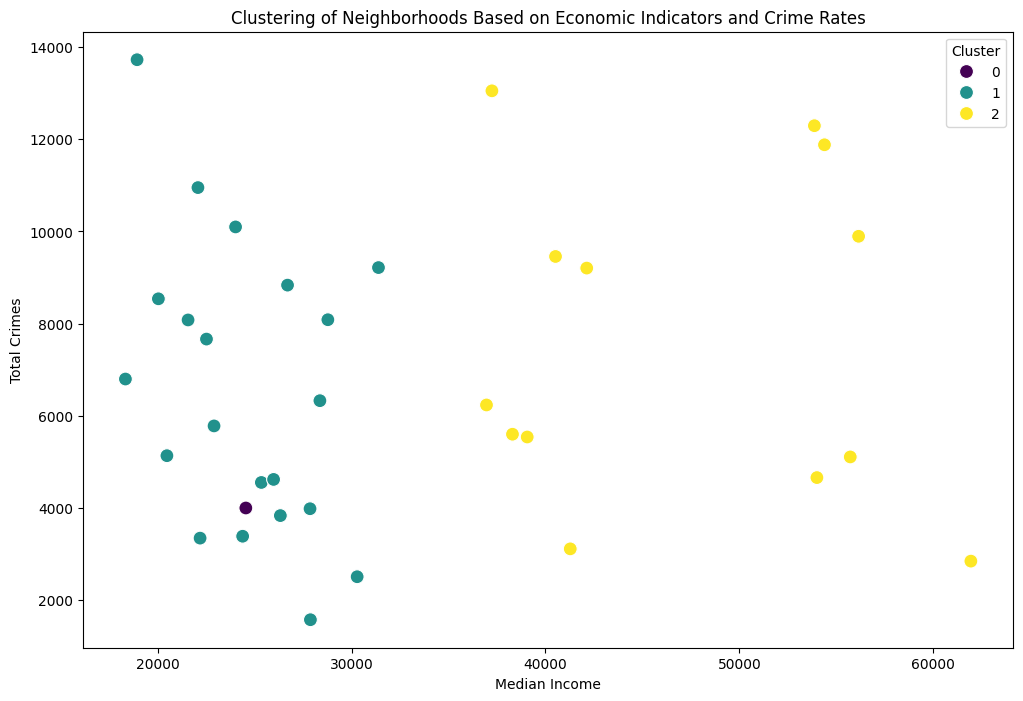

Cluster Summary Statistics:
  Cluster Median Income              Poverty Rate            \
                   mean          std         mean       std   
0       0  24550.000000          NaN    35.420000       NaN   
1       1  24590.714286  3737.079169    39.200000  7.193410   
2       2  47043.076923  8976.672903    21.166923  7.837212   

  Labor Force Participation Rate           Employment Rate            \
                            mean       std            mean       std   
0                      32.840000       NaN       87.600000       NaN   
1                      53.010952  5.300973       86.425238  4.494110   
2                      63.290000  7.410708       92.176154  3.111941   

  Government Employment Rate           Self-Employment Rate            \
                        mean       std                 mean       std   
0                  27.110000       NaN             0.000000       NaN   
1                  13.706190  4.010971             3.829048  2.267309   
2  

C:\Users\rithv\AppData\Local\Temp\ipykernel_10072\3146066534.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Median Income', data=combined_data, palette='viridis', ax=axes[0, 0])
C:\Users\rithv\AppData\Local\Temp\ipykernel_10072\3146066534.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Poverty Rate', data=combined_data, palette='viridis', ax=axes[0, 1])
C:\Users\rithv\AppData\Local\Temp\ipykernel_10072\3146066534.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Labor Force Partic

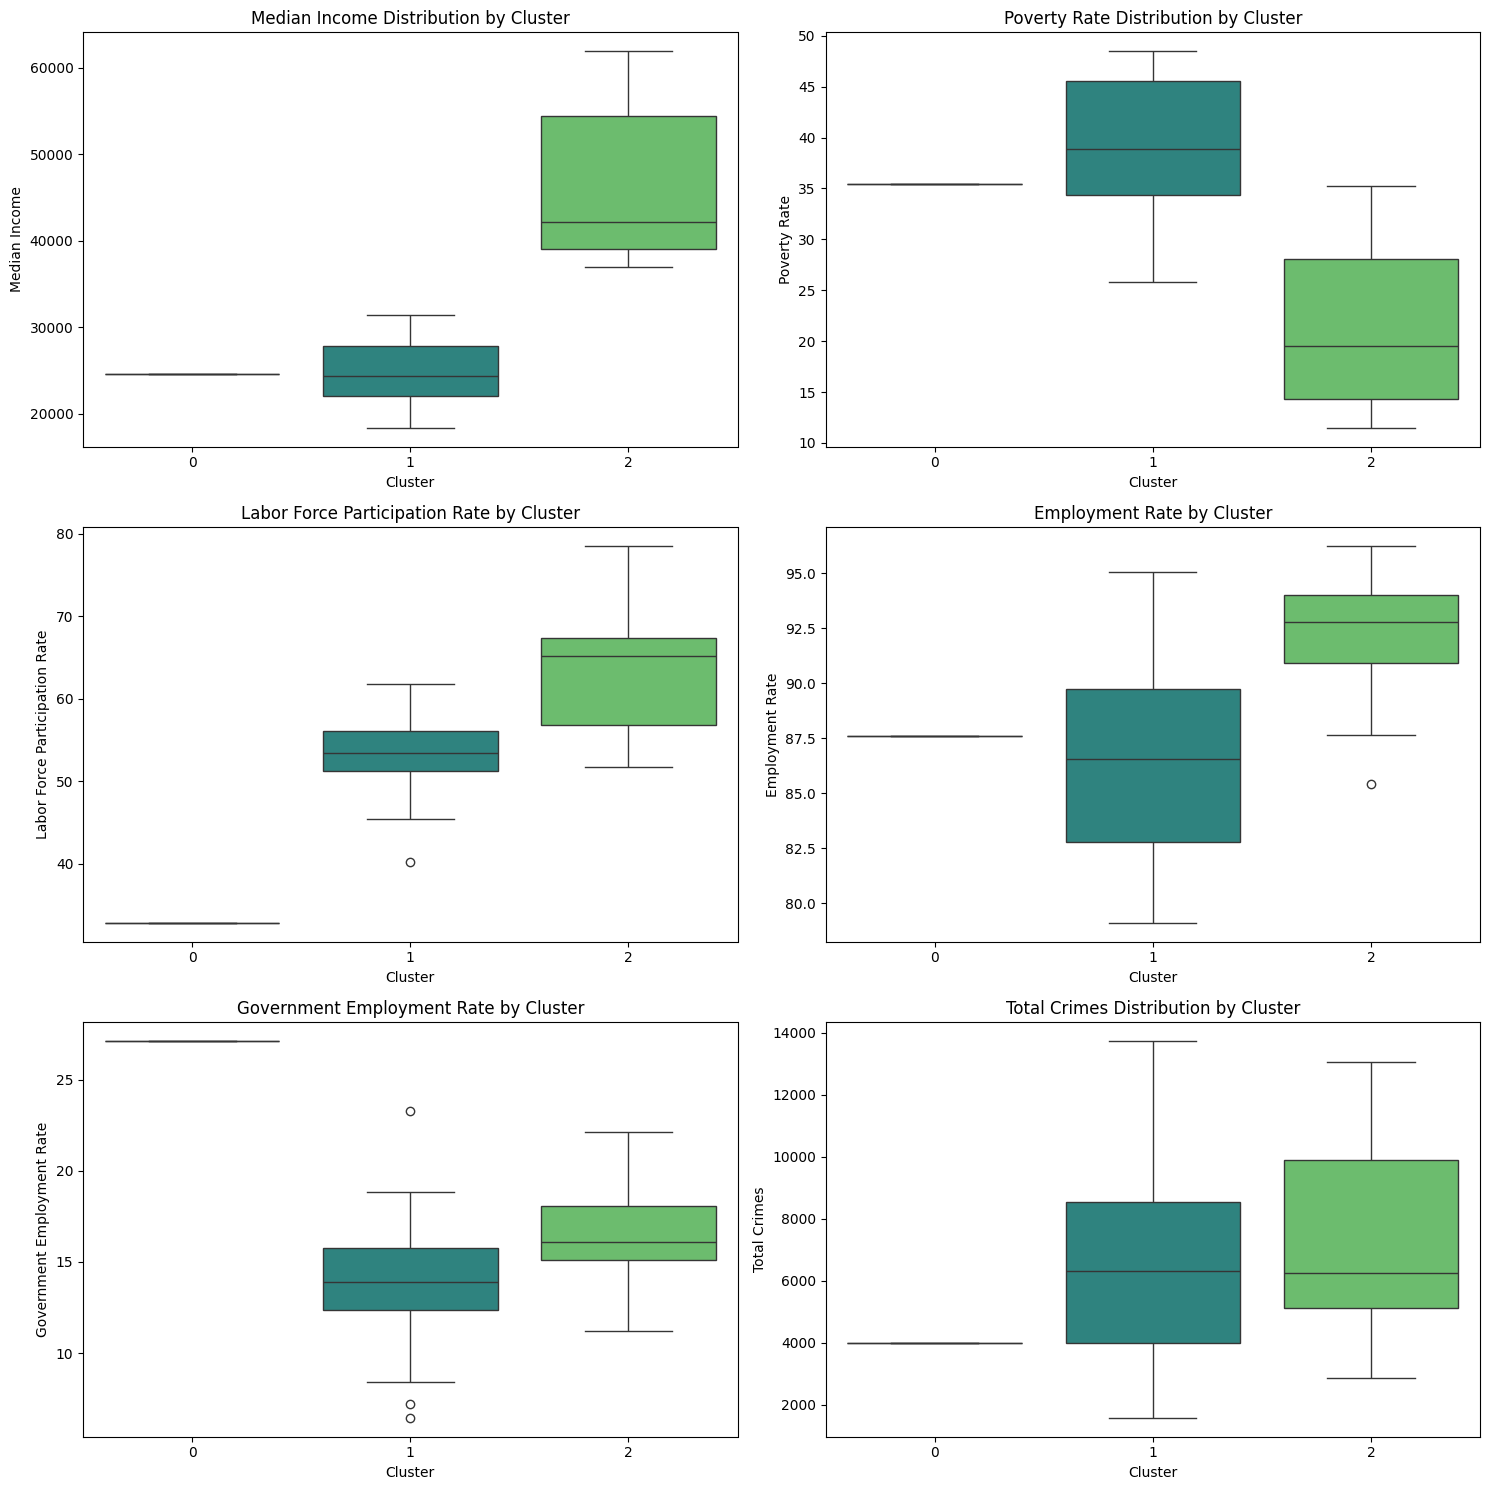

In [23]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
crime_data_path = df_filtered
economic_data_path = 'data/Neighborhood_Metrics_50608493.csv'

# Load the dataset
economic_data = pd.read_csv(economic_data_path)

# Aggregate crime data by neighborhood
crime_counts_by_neighborhood = crime_data['neighborhood'].value_counts().reset_index()
crime_counts_by_neighborhood.columns = ['Neighborhood', 'Total Crimes']

# Merge crime counts with economic data
combined_data = pd.merge(economic_data, crime_counts_by_neighborhood, on='Neighborhood', how='left')

# Selecting additional economic indicators along with crime data for clustering
features = [
    'Median Income', 'Poverty Rate', 'Labor Force Participation Rate', 'Employment Rate',
    'Government Employment Rate', 'Self-Employment Rate', 'Total Crimes'
]

# Drop any rows with missing values in selected features
cluster_data = combined_data[features].dropna()

# Scaling the features for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original data for analysis
combined_data['Cluster'] = -1  # Initialize with -1 for non-matching indices
combined_data.loc[cluster_data.index, 'Cluster'] = cluster_labels

# Visualization of clusters with respect to economic indicators and crime rates
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Median Income', y='Total Crimes', hue='Cluster', data=combined_data, palette='viridis', s=100)
plt.title('Clustering of Neighborhoods Based on Economic Indicators and Crime Rates')
plt.xlabel('Median Income')
plt.ylabel('Total Crimes')
plt.legend(title='Cluster')
plt.show()

# Statistical summary of clusters
cluster_summary = combined_data.groupby('Cluster').agg({
    'Median Income': ['mean', 'std'],
    'Poverty Rate': ['mean', 'std'],
    'Labor Force Participation Rate': ['mean', 'std'],
    'Employment Rate': ['mean', 'std'],
    'Government Employment Rate': ['mean', 'std'],
    'Self-Employment Rate': ['mean', 'std'],
    'Total Crimes': ['mean', 'std', 'count']
}).reset_index()

print("Cluster Summary Statistics:")
print(cluster_summary)

# Boxplots for visualizing the distribution of economic indicators by Cluster
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.boxplot(x='Cluster', y='Median Income', data=combined_data, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Median Income Distribution by Cluster')

sns.boxplot(x='Cluster', y='Poverty Rate', data=combined_data, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Poverty Rate Distribution by Cluster')

sns.boxplot(x='Cluster', y='Labor Force Participation Rate', data=combined_data, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Labor Force Participation Rate by Cluster')

sns.boxplot(x='Cluster', y='Employment Rate', data=combined_data, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Employment Rate by Cluster')

sns.boxplot(x='Cluster', y='Government Employment Rate', data=combined_data, palette='viridis', ax=axes[2, 0])
axes[2, 0].set_title('Government Employment Rate by Cluster')

sns.boxplot(x='Cluster', y='Total Crimes', data=combined_data, palette='viridis', ax=axes[2, 1])
axes[2, 1].set_title('Total Crimes Distribution by Cluster')

plt.tight_layout()
plt.show()



#### Algorithm Choice: K means Clustering
For this analysis, I chose K-Means Clustering to explore relationships between socio-economic factors and crime rates across neighborhoods. is approach helped us analyze and visualize how neighborhoods with similar socio-economic indicators compare in terms of crime rates. The clustering process enabled straightforward interpretation of results, making it easier to identify profiles (e.g., high poverty with moderate crime, high income with high crime) and examine the characteristics of each. It is effective for datasets with multiple features, which is essential for this analysis. Our dataset included multiple economic indicators (e.g., median income, poverty rate, employment rate) and the total crime count, each contributing uniquely to the clustering process. K-Means allowed us to capture the combined impact of these factors in a multi-dimensional space, effectively grouping neighborhoods based on their overall economic and crime profiles.

#### Additional Dataset for Economic Factors
An additional dataset with socio-economic indicators (e.g., **Median Income**, **Poverty Rate**, **Employment Rate**) was included to enrich the analysis. This dataset provided essential context, allowing us to examine potential correlations between economic factors and crime rates across neighborhoods.

#### Model Effectiveness and Insights
After clustering, statistical summaries and visualizations revealed distinct profiles:
- **Cluster 0**: Low income and high poverty, with moderate crime rates. High reliance on government employment.
- **Cluster 1**: High poverty, low to moderate income, and variable crime levels.
- **Cluster 2**: High income and low poverty, but surprisingly high crime rates, suggesting non-economic factors may drive crime here.


### Insights Gained

#### Overall Relationships
- **Income and Poverty**: Lower-income neighborhoods (Clusters 0 and 1) tend to experience higher crime rates, but the wealthiest neighborhoods (Cluster 2) also face high crime. This suggests that while poverty correlates with crime, higher income alone doesn’t ensure lower crime.

- **Labor Force and Employment**: Higher labor force participation and employment rates (Cluster 2) don’t necessarily result in lower crime, indicating that employment stability is not the only factor influencing crime.

- **Government and Self-Employment Rates**: Cluster 0's high reliance on government employment and lack of self-employment may indicate limited economic opportunities, but this doesn’t lead to the highest crime rates.

#### Conclusion
While poverty and low income are associated with higher crime, affluent areas also experience high crime, implying that economic uplift alone may not reduce crime. This highlights the importance of additional social or environmental interventions in high-income neighborhoods to address crime.
